# **Task**

**What kind of experiences/triggers leads to an increased likelihood of a session ending?**

# **Analysis Workflow**
**1. Data Loading and Cleaning**

**2. Exploratory Data Analysis and Feature Engineering**

**3. Explanatory Modeling (Why is this the last bet?)**

**4. Predictive Modeling (Will this be the last bet?)**

# **Data loading and cleaning**

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

Load and examine data

In [ ]:
betdata = pd.read_csv('BetData_ForCandidates.csv')

In [ ]:
betdata.head()

,gameutctime,betWager,betPayout,sessionBalance,userid_masked,sessionid_masked
0,2020-05-21 13:13:36.470,2.25,0.0,309.97,5340,846050959
1,2020-05-21 13:13:37.860,2.25,0.0,307.72,5340,846050959
2,2020-05-21 13:13:39.750,2.25,0.0,305.47,5340,846050959
3,2020-05-21 13:13:41.567,2.25,0.0,303.22,5340,846050959
4,2020-05-21 13:13:43.810,2.25,0.0,300.97,5340,846050959


Check data dimensions and data types
- Low dimensional raw dataset with lots of rows (unique bets)
- gameutctime can be converted to datetime format later

In [ ]:
print("Number of rows: {}\nNumber of columns: {}".format(betdata.shape[0], betdata.shape[1]))

Number of rows: 2487382
Number of columns: 6


In [ ]:
betdata.dtypes

gameutctime          object
betWager            float64
betPayout           float64
sessionBalance      float64
userid_masked         int64
sessionid_masked      int64
dtype: object

**Data Dictionary**

---

**gameutctime:** Timestamp of when the bet occurred

**betWager:** Amount of money that the player puts up for the bet

**betPayout:** Amount of money that the player receives from the bet (this will be 0 in most cases because most bets do not pay out) (if betPayout < betWager he has effectively lost money on that bet and vice versa)

**sessionBalance:** Amount of money that the player sees in his account after the betWager and betPayout amounts have been logged in the system (the session balances from bet to bet don’t always reconcile on wagers and payouts alone because sometimes the player can debit/credit funds from/into his account)

**userid_masked:** unique identifier of a player

**sessionid_masked:** unique identifier of a session (the last bet in each session is the ‘session-ending’ bet)

---

Check for missing values and duplicate rows
- No missing values
- No duplicated rows (gameutctime + sessionid_masked should keep all rows unique)

In [ ]:
betdata.isna().sum()

gameutctime         0
betWager            0
betPayout           0
sessionBalance      0
userid_masked       0
sessionid_masked    0
dtype: int64

In [ ]:
betdata[betdata.duplicated() == True]

,gameutctime,betWager,betPayout,sessionBalance,userid_masked,sessionid_masked


Data validity check
- No negative bet wager
- No negative bet payout
- No negative session balance

In [ ]:
betdata[(betdata['betWager'] < 0) | (betdata['betPayout'] < 0) | (betdata['sessionBalance'] < 0)]

,gameutctime,betWager,betPayout,sessionBalance,userid_masked,sessionid_masked


Check number of unique values in each column for some basic understanding of dota
- gameutctime can be repeated where different players start a bet simultaneously
- Bet wager exists in 10 different amounts (based on this dataset)
- Bet payout depends on the bet wager and the payout percentage (mostly 0 as most bets do not pay out)
- 4036 unique users 
- 8435 sessions 

In [ ]:
betdata.nunique()

gameutctime         2441545
betWager                 10
betPayout               742
sessionBalance       309705
userid_masked          4036
sessionid_masked       8435
dtype: int64

Descriptive statistics of the following 3 columns
- betWager	
- betPayout (mean bet payout > mean bet wager)
  - A player can expect to receive back (13.26 / 13.74) * 100 = **96.50 dollars for every 100 dollars they wager.**
  - House edge ~3.5%
- sessionBalance
  - Most players' balances hover below $1000 with some extreme cases at few hundred thousand dollars

In [ ]:
betdata.iloc[:, 1:4].describe().round(2)[1:]

,betWager,betPayout,sessionBalance
mean,13.74,13.26,1182.10
std,39.26,141.71,8117.79
min,2.25,0.00,0.00
25%,2.25,0.00,115.08
50%,4.50,0.00,294.83
75%,9.00,2.50,741.35
max,900.00,50500.00,382191.50


# **Exploratory Data Analysis and Feature Engineering**
- Visualizations
- Hypothesis testing
- Creation of binary label
- Creation of informative features

## **Countplot of Bet Wager**
- Most bet wagers are small (2.25, 4.5, 9.0, 18.0)
- Subsequent wager values tend to double in size
  - 2.25 * 2 = 4.5
  - 4.5 * 2 = 9.0

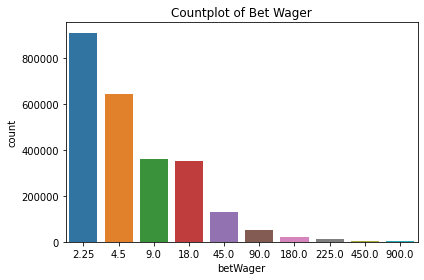

In [ ]:
sns.countplot(x = "betWager", data = betdata)
plt.title("Countplot of Bet Wager")
plt.tight_layout()
plt.show()

## **Density Plot of Bet Payout**
- Right-skewed distribution where most payouts are 0
- Correspond to the bet wager distribution where most wagers are small bets which lead to smaller sized payouts as well

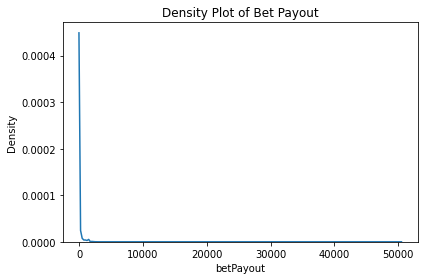

In [ ]:
sns.kdeplot(betdata["betPayout"])
plt.title("Density Plot of Bet Payout")
plt.tight_layout()
plt.show()

## **Distribution of Bet Payouts for Different Bet Wagers**
- For each wager, approximately 50% of the bets will receive payouts that are half the value of the wager and below.

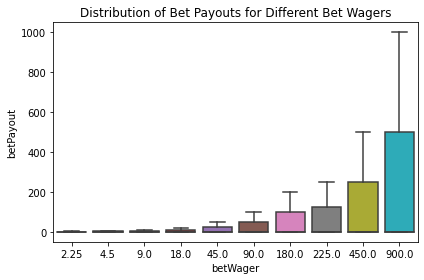

In [ ]:
sns.boxplot(betdata["betWager"], betdata["betPayout"], showfliers = False)
plt.title("Distribution of Bet Payouts for Different Bet Wagers")
plt.tight_layout()
plt.show()

## **Boxplots of Session Balance (With and without extremely large values)**
- Most session balances lie within the 100-800 range
- Some players have session balances of up to a few hundred thousand dollars

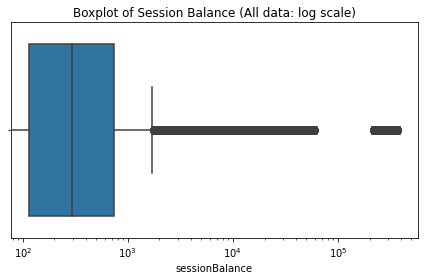

In [ ]:
sns.boxplot(betdata["sessionBalance"], showfliers = True)
plt.title("Boxplot of Session Balance (All data: log scale)")
plt.xscale('log')
plt.tight_layout()
plt.show()

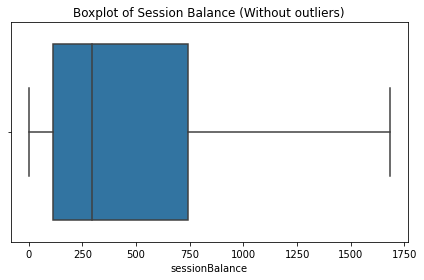

In [ ]:
sns.boxplot(betdata["sessionBalance"], showfliers = False)
plt.title("Boxplot of Session Balance (Without outliers)")
plt.tight_layout()
plt.show()

## **Barplot of Total Number of Sessions for Most Frequent Players**
- Show top 40 as an example (space constraint)

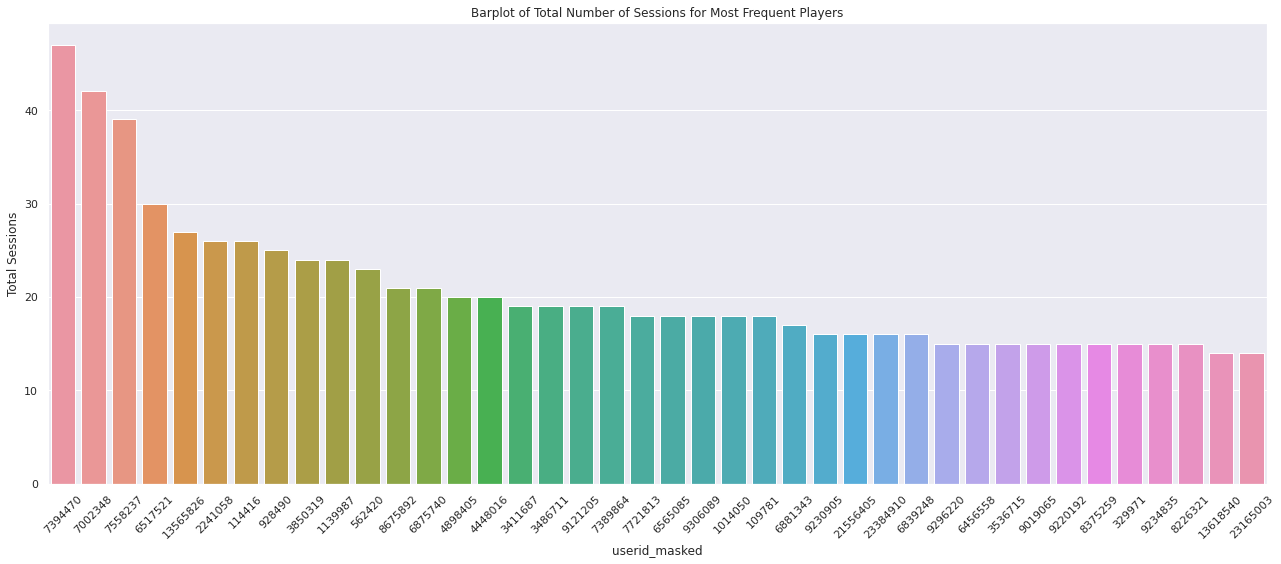

In [ ]:
total_sessions_per_user = pd.DataFrame(betdata.groupby(betdata['userid_masked'])['sessionid_masked'].nunique()).sort_values('sessionid_masked', ascending = False).head(40)
sns.set(rc = {"figure.figsize": (18, 8)})
sns.barplot(total_sessions_per_user.index, total_sessions_per_user['sessionid_masked'], order = total_sessions_per_user.index)
plt.title("Barplot of Total Number of Sessions for Most Frequent Players")
plt.ylabel('Total Sessions')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## **Countplot of Total Sessions Distribution**
- Most players (>90%) leave after 1-5 sessions
- Only minority of players play more than 5 sessions

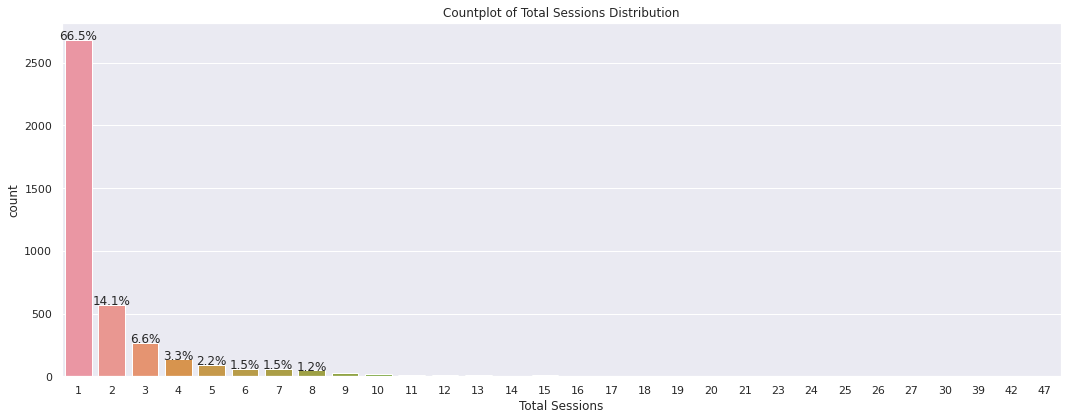

In [ ]:
total_sessions_per_user_dist = pd.DataFrame(betdata.groupby(betdata['userid_masked'])['sessionid_masked'].nunique()).sort_values('sessionid_masked', ascending = False)
sns.set(rc = {"figure.figsize": (15, 6)})
total = float(len(total_sessions_per_user_dist))
ax = sns.countplot(x = "sessionid_masked", data = total_sessions_per_user_dist)
plt.title("Countplot of Total Sessions Distribution")
for p in ax.patches[0:8]:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha = 'center')
plt.xlabel('Total Sessions')
plt.tight_layout()
plt.show()

## **Binary class label to facilitate supervised learning**

Create a column 'session_ending_bet' indicating whether the particular bet is the session's last bet (to be used as label for explantory and predictive purposes: binary classification)
- 1 = Yes
- 0 = No

In [ ]:
betdata['session_ending_bet'] = np.where(betdata['gameutctime'] == betdata.groupby('sessionid_masked')['gameutctime'].transform('max'), 1, 0)

In [ ]:
betdata['session_ending_bet'] = betdata['session_ending_bet'].astype('category')

In [ ]:
betdata['session_ending_bet'].value_counts()

0    2478947
1       8435
Name: session_ending_bet, dtype: int64

In [ ]:
betdata['session_ending_bet'].value_counts(normalize = True) * 100

0    99.660888
1     0.339112
Name: session_ending_bet, dtype: float64

In [ ]:
betdata.head(927)

,gameutctime,betWager,betPayout,sessionBalance,userid_masked,sessionid_masked,session_ending_bet
0,2020-05-21 13:13:36.470,2.25,0.0,309.97,5340,846050959,0
1,2020-05-21 13:13:37.860,2.25,0.0,307.72,5340,846050959,0
2,2020-05-21 13:13:39.750,2.25,0.0,305.47,5340,846050959,0
3,2020-05-21 13:13:41.567,2.25,0.0,303.22,5340,846050959,0
4,2020-05-21 13:13:43.810,2.25,0.0,300.97,5340,846050959,0
...,...,...,...,...,...,...,...
922,2020-05-21 13:57:25.510,2.25,0.0,652.97,5340,846050959,0
923,2020-05-21 13:57:29.613,2.25,0.0,650.72,5340,846050959,1
924,2020-05-23 05:10:51.160,18.00,0.0,187.02,18718,438576893,0
925,2020-05-23 05:10:54.017,18.00,110.0,279.02,18718,438576893,0


**Distribution of bet wager based on whether the session ended (outliers hidden)**
- Can observe that if the session ended, the final bet wager is on the lower side.
- However, this doesn't work in reverse as low bet wagers are much more common.
  - i.e. cannot predict a session's last bet based solely on low bet wager

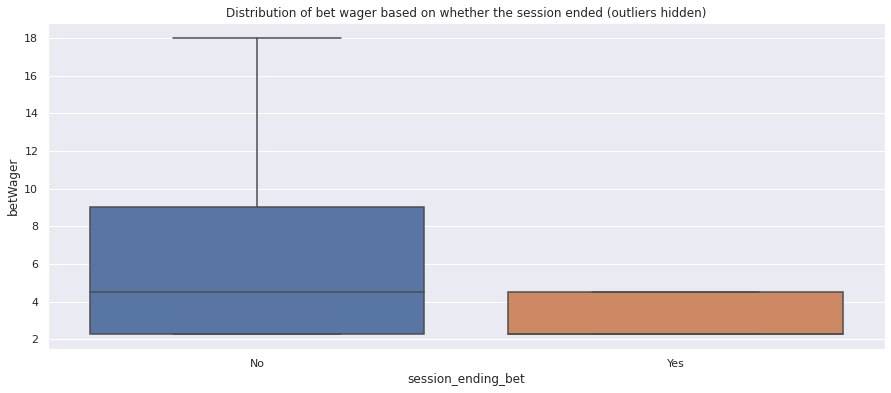

In [ ]:
sns.boxplot(x = "session_ending_bet", y = "betWager", data = betdata, showfliers = False)
plt.title("Distribution of bet wager based on whether the session ended (outliers hidden)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

**Distribution of bet payout based on whether the session ended (outliers hidden)**
- Can observe that if the session ended, bet payout is usually 0.
- However, this doesn't work in reverse as bet payout of 0 is very common.
  - i.e. cannot predict a session's last bet based solely on bet payout of 0

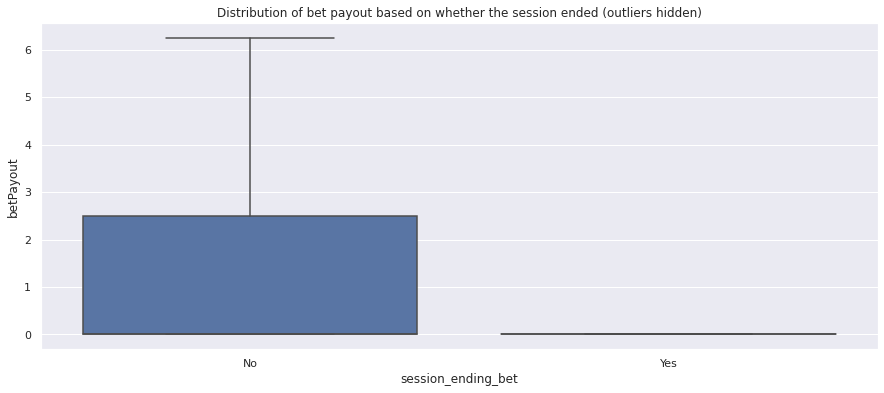

In [ ]:
sns.boxplot(x = "session_ending_bet", y = "betPayout", data = betdata, showfliers = False)
plt.title("Distribution of bet payout based on whether the session ended (outliers hidden)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

**Distribution of session balance based on whether the session ended (outliers hidden)**
- Can observe that if the session ended, session balance tends to be low.
- However, this doesn't work in reverse as most players have low balances throughout.
  - i.e. cannot predict a session's last bet based solely on low session balances

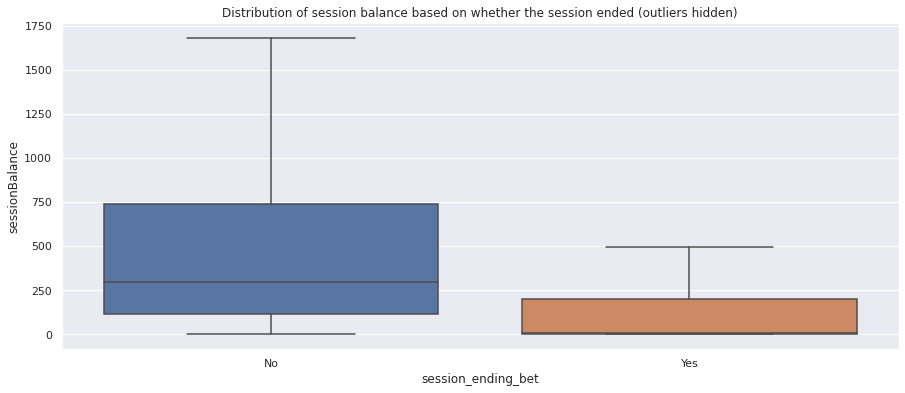

In [ ]:
sns.boxplot(x = "session_ending_bet", y = "sessionBalance", data = betdata, showfliers = False)
plt.title("Distribution of session balance based on whether the session ended (outliers hidden)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

## **Engineered feature: 'lost_money'** 
- Indicates whether the player lost money on a particular bet
  - 1 = Yes
  - 0 = No

- If betPayout < betWager, the player has effectively lost money on that bet and vice versa

In [ ]:
betdata['lost_money'] = np.where(betdata['betWager'] > betdata['betPayout'], 1, 0)

In [ ]:
betdata['lost_money'] = betdata['lost_money'].astype('category')

In [ ]:
betdata.head(10)

,gameutctime,betWager,betPayout,sessionBalance,userid_masked,sessionid_masked,session_ending_bet,lost_money
0,2020-05-21 13:13:36.470,2.25,0.00,309.97,5340,846050959,0,1
1,2020-05-21 13:13:37.860,2.25,0.00,307.72,5340,846050959,0,1
2,2020-05-21 13:13:39.750,2.25,0.00,305.47,5340,846050959,0,1
3,2020-05-21 13:13:41.567,2.25,0.00,303.22,5340,846050959,0,1
4,2020-05-21 13:13:43.810,2.25,0.00,300.97,5340,846050959,0,1
5,2020-05-21 13:13:46.180,2.25,6.25,304.97,5340,846050959,0,0
6,2020-05-21 13:13:48.960,2.25,0.00,302.72,5340,846050959,0,1
7,2020-05-21 13:13:50.517,2.25,15.00,315.47,5340,846050959,0,0
8,2020-05-21 13:13:54.097,2.25,0.00,313.22,5340,846050959,0,1
9,2020-05-21 13:13:55.720,2.25,7.50,318.47,5340,846050959,0,0


**Chi-Square Test for Independence Between Categorical Variables**
- Null hypothesis: There is no significant relationship between 'lost_money' and 'session_ending_bet'.
- Alternative hypothesis: There is a significant relationship between 'lost_money' and 'session_ending_bet'.

Significance level (α): 0.05

Since the p-value (1.02e-254) is smaller than our chosen significance level (α = 0.05), there is sufficient evidence to reject the null hypothesis and conclude that there is a significant relationship between 'lost_money' and 'session_ending_bet'.

Limitation: A chi-square value can not tell you what the relationship is between two variables, only that a relationship exists between the two variables

In [ ]:
ct = pd.crosstab(betdata.session_ending_bet, betdata.lost_money, margins = True)
obs = np.array([ct.iloc[0].values,
                ct.iloc[1].values])
print("X² statistic: {}\np-value: {}".format(round(scipy.stats.chi2_contingency(obs, correction = False)[0], 2),
                                             scipy.stats.chi2_contingency(obs, correction = False)[1]))

X² statistic: 1169.66
p-value: 1.0247429731433871e-254


**Session ending bet count based on whether the player lost money (log scale)**
- Can observe that if the player lost money in a bet, there is a higher chance (close to an order of magnitude) that the bet might be the last bet for the session as compared to not losing money.
- Issue: Losing money is very common (high prevalence within the target population).
  - Cannot accurately predict a session's last bet based solely on losing money
  - i.e. Simple heuristic: If we predict all money-losing bets to be the last bets, there would be many false positives.

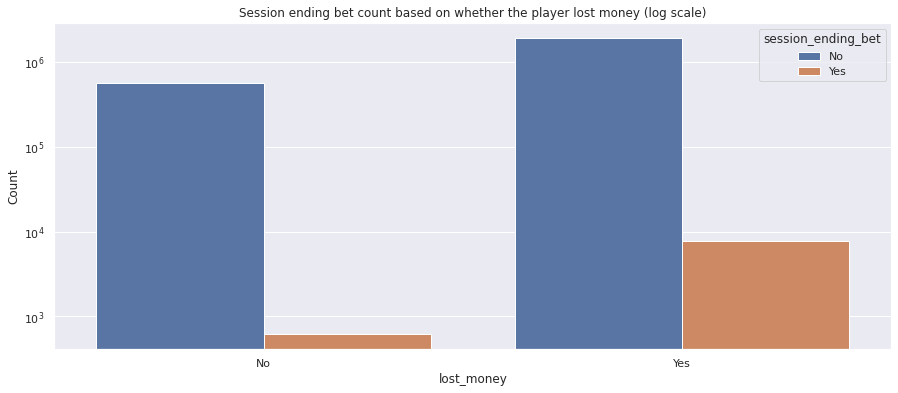

In [ ]:
g = sns.countplot(x = "lost_money", hue = "session_ending_bet", data = betdata)
plt.title("Session ending bet count based on whether the player lost money (log scale)")
plt.ylabel("Count")
plt.yscale("log")
plt.xticks([0, 1], ['No', 'Yes'])
L = plt.legend(title = "session_ending_bet")
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')
plt.show()

**Convert 'gameutctime' from object to datetime64[ns] data type**
- To facilitate the creation of time-based features and/or manipulation of timestamps

In [ ]:
betdata['gameutctime'] = pd.to_datetime(betdata['gameutctime'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
betdata.dtypes

gameutctime           datetime64[ns]
betWager                     float64
betPayout                    float64
sessionBalance               float64
userid_masked                  int64
sessionid_masked               int64
session_ending_bet          category
lost_money                  category
dtype: object

## **Engineered feature: 'lowered_wager'** 
- Indicates whether the player lowered the wager relative to the last bet
  - 1 = Yes
  - 0 = No

- If betWager[i] < betWager[i-1], the player has lowered the wager

In [ ]:
betdata['lowered_wager'] = np.where(betdata['betWager'] < betdata['betWager'].shift(), 1, 0)

In [ ]:
betdata['lowered_wager'] = betdata['lowered_wager'].astype('category')

In [ ]:
betdata.tail(5)

,gameutctime,betWager,betPayout,sessionBalance,userid_masked,sessionid_masked,session_ending_bet,lost_money,lowered_wager
2487377,2020-05-23 19:50:11.497,4.50,2.5,917.40,23453788,424576703,0,1,0
2487378,2020-05-23 19:50:15.180,4.50,0.0,912.90,23453788,424576703,0,1,0
2487379,2020-05-23 19:50:19.040,4.50,0.0,908.40,23453788,424576703,0,1,0
2487380,2020-05-23 19:50:21.903,4.50,0.0,903.90,23453788,424576703,0,1,0
2487381,2020-05-23 19:50:28.620,2.25,0.0,901.65,23453788,424576703,1,1,1


**Chi-Square Test for Independence Between Categorical Variables**
- Null hypothesis: There is no significant relationship between 'lowered_wager' and 'session_ending_bet'.
- Alternative hypothesis: There is a significant relationship between 'lowered_wager' and 'session_ending_bet'.

Significance level (α): 0.05

Since the p-value (0.0) is smaller than our chosen significance level (α = 0.05), there is sufficient evidence to reject the null hypothesis and conclude that there is a significant relationship between 'lowered_wager' and 'session_ending_bet'.

In [ ]:
ct = pd.crosstab(betdata.session_ending_bet, betdata.lowered_wager, margins = True)
obs = np.array([ct.iloc[0].values,
                ct.iloc[1].values])
print("X² statistic: {}\np-value: {}".format(round(scipy.stats.chi2_contingency(obs, correction = False)[0], 2),
                                             scipy.stats.chi2_contingency(obs, correction = False)[1]))

X² statistic: 12720.26
p-value: 0.0


**Session ending bet percentage based on whether the player lowered wager**
- Can observe that if the player lowered wager in a bet, there is a higher probability that the bet might be the last bet for the session as compared to not lowering the wager.
- Issue: Lowering wager doesn't happen most of the time.
  - Cannot accurately predict a session's last bet based solely on lowering wager
  - i.e. Simple heuristic: If we only predict all wager-lowering bets to be the last bets, there would be many false negatives (failure to detect those who ended the session even though they never lowered their wagers).

In [ ]:
new_df = betdata.groupby("lowered_wager")["session_ending_bet"].value_counts(normalize = True)
new_df = new_df.mul(100).rename('Percent').reset_index()
new_df.rename(columns = {"level_1": "session_ending_bet"}, inplace = True)

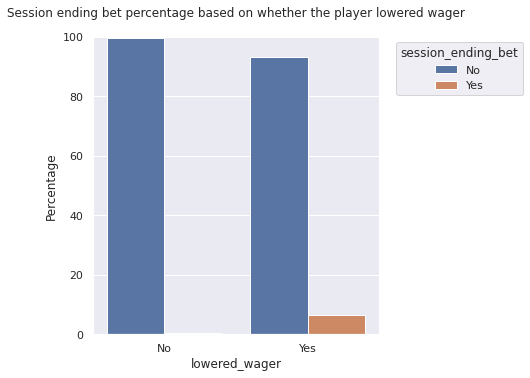

In [ ]:
g = sns.catplot(x = "lowered_wager", y = 'Percent', hue = "session_ending_bet", kind = 'bar', data = new_df, legend = False)
g.ax.set_ylim(0, 100)
plt.title("Session ending bet percentage based on whether the player lowered wager", pad = 20)
plt.ylabel("Percentage")
plt.xticks([0, 1], ['No', 'Yes'])
L = plt.legend(title = "session_ending_bet", bbox_to_anchor = (1.04, 1))
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')
plt.show()

## **Engineered feature: 'sess_len_min'** 
- Indicates how many minutes have passed since the start of the session
- Proxy of physical/mental fatigue after a certain period of time
  - Differ between individuals but should approximately average out (e.g. casual vs serious players)

In [ ]:
gameutctime_min = pd.DataFrame(betdata['gameutctime'].groupby(betdata['sessionid_masked']).min())

In [ ]:
betdata = betdata.merge(gameutctime_min,
                        how = 'inner',
                        left_on = 'sessionid_masked',
                        right_on = gameutctime_min.index)

In [ ]:
betdata['sess_len_min'] = np.floor((betdata['gameutctime_x'] - betdata['gameutctime_y']) / np.timedelta64(1, 'm')).astype(int)

In [ ]:
betdata.rename(columns = {'gameutctime_x': 'gameutctime'}, inplace = True)
betdata.drop(columns = {'gameutctime_y'}, inplace = True)

In [ ]:
betdata.loc[2487365:2487370, ]

,gameutctime,betWager,betPayout,sessionBalance,userid_masked,sessionid_masked,session_ending_bet,lost_money,lowered_wager,sess_len_min,withdrew_funds,loss_streak_counter
2487365,2020-05-23 19:49:29.033,4.5,0.0,937.4,23453788,424576703,0,1,0,0,0,4
2487366,2020-05-23 19:49:31.557,4.5,0.0,932.9,23453788,424576703,0,1,0,0,0,5
2487367,2020-05-23 19:49:34.463,4.5,7.5,935.9,23453788,424576703,0,0,0,1,0,0
2487368,2020-05-23 19:49:38.320,4.5,0.0,931.4,23453788,424576703,0,1,0,1,0,1
2487369,2020-05-23 19:49:42.650,4.5,0.0,926.9,23453788,424576703,0,1,0,1,0,2
2487370,2020-05-23 19:49:45.383,4.5,7.5,929.9,23453788,424576703,0,0,0,1,0,0


**Distribution of current session length, in minutes, based on whether the session ended (outliers hidden)**
- Most sessions tend to end quite fast (less than 25 minutes)
- Sessions that go beyond 25 minutes tend to go on for much longer amount of time (wider body from median to upper quartile as compared to the lower quartile)

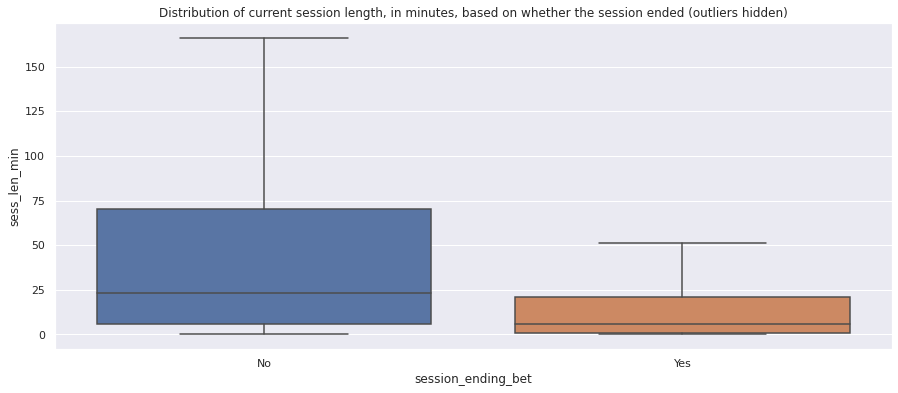

In [ ]:
sns.boxplot(x = 'session_ending_bet', y = 'sess_len_min', data = betdata, showfliers = False)
plt.title("Distribution of current session length, in minutes, based on whether the session ended (outliers hidden)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

**Welch’s t-test (used to test if the means of two populations are equal)**

Assumptions: 

1) The independent variable (IV) is categorical with at least two levels (groups)

2) The dependent variable (DV) is continuous which is measured on an interval or ratio scale

3) The distribution of the two groups should follow the normal distribution
- If n >= 30, assumption is fulfilled using central limit theorem

- Null hypothesis: The session length mean of session-ending bet is equal to the session length mean of non session-ending bet.
- Alternative hypothesis: The session length mean of session-ending bet is not equal to the session length mean of non session-ending bet.

Significance level (α): 0.05

t-score: -84.5045763414884

Since the p-value (0.0) is smaller than our chosen significance level (α = 0.05), there is sufficient evidence to reject the null hypothesis and conclude that the session length mean of session-ending bet is not equal to the session length mean of non session-ending bet.

In [ ]:
session_ended = betdata[(betdata['session_ending_bet'] == 1)]
session_not_ended = betdata[(betdata['session_ending_bet'] == 0)]

In [ ]:
stats.ttest_ind(session_ended['sess_len_min'], session_not_ended['sess_len_min'], equal_var = False)

Ttest_indResult(statistic=-84.5045763414884, pvalue=0.0)

## **Engineered feature: 'withdrew_funds'** 
- Indicates whether the player withdrew funds from the account
- Might be a sign that the player is about to stop playing
  - Low session balance
  - Achieved target amount for the session

In [ ]:
betdata['withdrew_funds'] = np.where(betdata['sessionBalance'] < (betdata['sessionBalance'].shift() + betdata['betPayout'] - betdata['betWager']), 1, 0)

In [ ]:
betdata['withdrew_funds'] = betdata['withdrew_funds'].astype('category')

In [ ]:
a = betdata[betdata['withdrew_funds'] == 1].tail(2)[['gameutctime', 'betWager', 'betPayout', 'sessionBalance', 'userid_masked',	'sessionid_masked', 'withdrew_funds']]
b = betdata[betdata['withdrew_funds'] == 0].head(2)[['gameutctime', 'betWager', 'betPayout', 'sessionBalance', 'userid_masked',	'sessionid_masked', 'withdrew_funds']]
pd.concat([a, b]).reset_index(drop = True)

,gameutctime,betWager,betPayout,sessionBalance,userid_masked,sessionid_masked,withdrew_funds
0,2020-05-23 20:49:53.267,2.25,0.0,7.30,23453762,424576370,1
1,2020-05-23 20:50:02.753,2.25,0.0,0.55,23453762,424576370,1
2,2020-05-21 13:13:36.470,2.25,0.0,309.97,5340,846050959,0
3,2020-05-21 13:13:37.860,2.25,0.0,307.72,5340,846050959,0


**Session ending bet percentage based on whether the player withdrew funds**

In [ ]:
new_df = betdata.groupby("withdrew_funds")["session_ending_bet"].value_counts(normalize = True)
new_df = new_df.mul(100).rename('Percent').reset_index()
new_df.rename(columns = {"level_1": "session_ending_bet"}, inplace = True)

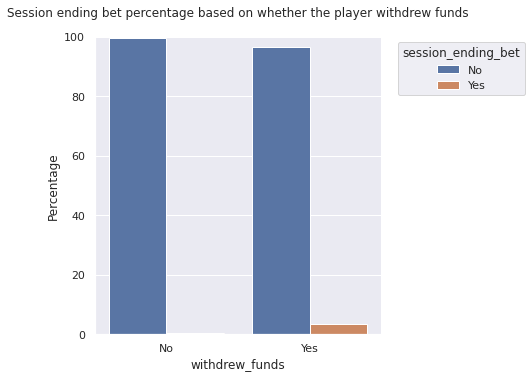

In [ ]:
g = sns.catplot(x = "withdrew_funds", y = 'Percent', hue = "session_ending_bet", kind = 'bar', data = new_df, legend = False)
g.ax.set_ylim(0, 100)
plt.title("Session ending bet percentage based on whether the player withdrew funds", pad = 20)
plt.ylabel("Percentage")
plt.xticks([0, 1], ['No', 'Yes'])
L = plt.legend(title = "session_ending_bet", bbox_to_anchor = (1.04, 1))
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')
plt.show()

**Chi-Square Test for Independence Between Categorical Variables**
- Null hypothesis: There is no significant relationship between 'withdrew_funds' and 'session_ending_bet'.
- Alternative hypothesis: There is a significant relationship between 'lowered_wager' and 'session_ending_bet'.

Significance level (α): 0.05

Since the p-value (0.0) is smaller than our chosen significance level (α = 0.05), there is sufficient evidence to reject the null hypothesis and conclude that there is a significant relationship between 'withdrew_funds' and 'session_ending_bet'.

In [ ]:
ct = pd.crosstab(betdata.session_ending_bet, betdata.withdrew_funds, margins = True)
obs = np.array([ct.iloc[0].values,
                ct.iloc[1].values])
print("X² statistic: {}\np-value: {}".format(round(scipy.stats.chi2_contingency(obs, correction = False)[0], 2),
                                             scipy.stats.chi2_contingency(obs, correction = False)[1]))

X² statistic: 13917.34
p-value: 0.0


## **Engineered feature: 'loss_streak_counter'** 
- Indicates the current loss streak of the player within a session
- Might affect the morale of the player and tendency to end the session
  - Luck has run out and should come back another time
  - Long loss streak can reduce session balance to an amount low enough to justify leaving

In [ ]:
betdata['loss_streak_counter'] = betdata['lost_money'].astype('int').groupby(betdata['sessionid_masked']).apply(lambda x: x * (x.groupby((x != x.shift()).cumsum()).cumcount() + 1))

In [ ]:
betdata.head(927)[['gameutctime', 'sessionid_masked', 'lost_money', 'loss_streak_counter']]

,gameutctime,sessionid_masked,lost_money,loss_streak_counter
0,2020-05-21 13:13:36.470,846050959,1,1
1,2020-05-21 13:13:37.860,846050959,1,2
2,2020-05-21 13:13:39.750,846050959,1,3
3,2020-05-21 13:13:41.567,846050959,1,4
4,2020-05-21 13:13:43.810,846050959,1,5
...,...,...,...,...
922,2020-05-21 13:57:25.510,846050959,1,2
923,2020-05-21 13:57:29.613,846050959,1,3
924,2020-05-23 05:10:51.160,438576893,1,1
925,2020-05-23 05:10:54.017,438576893,0,0


**Distribution of loss streak counter based on whether the session ended (outliers hidden)**
- Visible higher loss streaks encountered when the bet is the last for the session as compared to when it's not 
- Session ending bets have median loss streaks of around 5 with half of them ranging between 2-8.

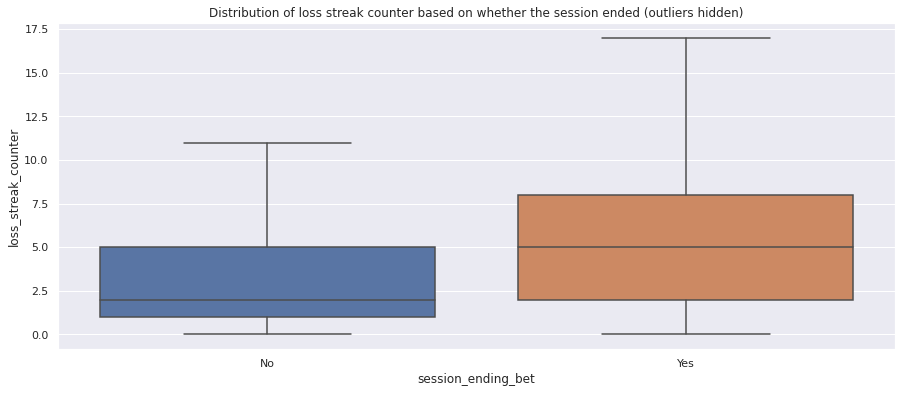

In [ ]:
sns.boxplot(x = 'session_ending_bet', y = 'loss_streak_counter', data = betdata, showfliers = False)
plt.title("Distribution of loss streak counter based on whether the session ended (outliers hidden)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

**Welch’s t-test (used to test if the means of two populations are equal)**
- Null hypothesis: The mean loss streak of session-ending bet is equal to the mean loss streak of non session-ending bet.
- Alternative hypothesis: The mean loss streak of session-ending bet is not equal to the mean loss streak of non session-ending bet.

Significance level (α): 0.05

t-score: 45.39200744605106

Since the p-value (0.0) is smaller than our chosen significance level (α = 0.05), there is sufficient evidence to reject the null hypothesis and conclude that the mean loss streak of session-ending bet is not equal to the mean loss streak of non session-ending bet.

In [ ]:
session_ended = betdata[(betdata['session_ending_bet'] == 1)]
session_not_ended = betdata[(betdata['session_ending_bet'] == 0)]

In [ ]:
stats.ttest_ind(session_ended['loss_streak_counter'], session_not_ended['loss_streak_counter'], equal_var = False)

Ttest_indResult(statistic=45.39200744605106, pvalue=0.0)

# **Explanatory Modeling (Why is this the last bet?)**
- Interested in identifying variables that are important and have a statistically significant relationship with an outcome (end session)
- Key steps
  - Fitting potentially theoretically important predictors
  - Checking for statistical significance
  - Evaluating effect sizes
  - Running diagnostics
- Train-test split is not required

## **Logistic regression**


In [ ]:
import statsmodels.api as sm

In [ ]:
betdata.dtypes

gameutctime            datetime64[ns]
betWager                      float64
betPayout                     float64
sessionBalance                float64
userid_masked                   int64
sessionid_masked                int64
session_ending_bet           category
lost_money                   category
lowered_wager                category
sess_len_min                    int64
withdrew_funds               category
loss_streak_counter             int64
dtype: object

In [ ]:
X = sm.add_constant(betdata[['lost_money', 'lowered_wager', 'sess_len_min', 'withdrew_funds', 'loss_streak_counter']])
y = betdata['session_ending_bet']

- Coefficient is interpreted as the expected change (increase/decrease) of the log odds as X changes, while controlling for the effects of other X variables
  - For categorical variables, the log odds is calculated with respect to the reference category
    - Here, the reference category is the label "0". Since our categorical variables are all binary, the coefficient is essentially the expected increase/decrease in the log odds of the session ending as we switch X from label "0" to label "1".
  - For continuous variables, the interpretation is simpler
    - For every 1 unit increase in X, the coefficient is the expected increase/decrease in the log odds of the session ending.
- "z values" are the ratio of the coefficient estimate (β) divided by the standard error of the estimator
  - A Z-value that is sufficiently far from 0 indicates that the coefficient estimate is both large and precise enough to be statistically different from 0

In [ ]:
log_reg_explain = sm.Logit(y, X)
log_reg_explain_result = log_reg_explain.fit()
print(log_reg_explain_result.summary2())

Optimization terminated successfully.
         Current function value: 0.020192
         Iterations 12
                           Results: Logit
Model:               Logit              Pseudo R-squared: 0.109      
Dependent Variable:  session_ending_bet AIC:              100464.5752
Date:                2022-03-21 19:59   BIC:              100540.9356
No. Observations:    2487382            Log-Likelihood:   -50226.    
Df Model:            5                  LL-Null:          -56387.    
Df Residuals:        2487376            LLR p-value:      0.0000     
Converged:           1.0000             Scale:            1.0000     
No. Iterations:      12.0000                                         
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const               -6.7218   0.0418 -160.6989 0.0000 -6.8038 -6.6398
lost_money     

- Odds Ratio Confidence Interval of Logistic Regression Model
  - If the 95% confidence interval for an odds ratio includes 1, it means that the results are not statistically significant
  - The odds of the event happening are the same in both groups (e.g. bet that lost money vs bet that did not lost money)
- Odds Ratio = (odds of the event in the exposed group) / (odds of the event in the non-exposed group)
  - Indicates the practical significance which refers to the effect size
  - Results are practically significant when the difference is large enough to be meaningful in real life (based on domain knowledge)
- Interpretation:
  - lost_money: The odds of a session ending when a player loses money is 2.59 times greater than when a player does not lose money.  	
  - lowered_wager: The odds of a session ending when a player lowers wager is 11.27 times greater than when a player does not lower wager.  	
  - sess_len_min: For every 1 minute increase in the session length, we can expect a 1.1% decrease in the odds of a session ending. 
  - withdrew_funds: The odds of a session ending when a player withdraws fund is 9.77 times greater than when a player does not withdraw fund.  
  - loss_streak_counter: For every 1 additional count of loss streak, we can expect a 8.9% increase in the odds of a session ending. 

In [ ]:
params = log_reg_explain_result.params
conf = log_reg_explain_result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
pd.DataFrame(np.exp(conf)).iloc[1:, ]

,5%,95%,Odds Ratio
lost_money,2.377556,2.825826,2.592018
lowered_wager,10.328266,12.288341,11.265755
sess_len_min,0.988572,0.989849,0.989210
withdrew_funds,9.234265,10.345398,9.774055
loss_streak_counter,1.084406,1.093641,1.089014


- Check for the absence of multicollinearity
- Calculate variance inflation factor (VIF)
  - Small VIF values indicates low correlation among variables under ideal conditions
  - The smallest possible value for VIF is 1, which indicates the complete absence of collinearity
  - VIFs between 1 and 5 suggest that the correlation is not severe enough to warrant corrective measures
- All the VIFs are less than 5 which are within the acceptable range

In [ ]:
cov = log_reg_explain_result.cov_params()
corr = cov / log_reg_explain_result.bse / log_reg_explain_result.bse[:, None]
vif = np.diag(np.linalg.inv(corr.values[1:, 1:]))
print("VIF\n------------------------------")
for i in range(len(vif)):
  print(corr.columns[1:].values[i], ": ", round(vif[i], 4))

VIF
------------------------------
lost_money :  1.0945
lowered_wager :  1.0501
sess_len_min :  1.005
withdrew_funds :  1.0529
loss_streak_counter :  1.0958


# **Predictive Modeling (Will this be the last bet?)**
- Interested in finding the strongest associations between predictor variables and the outcome variable to generate good predictions (session-ending bet or not).
- Less concerned about explaining why a variable is important in predicting the outcome (session-ending bet or not).
- Chosen variables in the predictive model are mainly based on association power, and less on statistical significance.
- A significant predictor based on hypothesis testing or explanatory modeling that adds no predictive benefit to the predictive model is usually excluded.
- Predictor variables that are significant but not available at the time of the observed outcome cannot be used in the predictive model.
- Train-test split is required to test how the trained predictive model performs on data it has never seen before.

## **Feature selection based on decision tree variable importance**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

Train-test split

In [ ]:
X = betdata[['lost_money', 'lowered_wager', 'sess_len_min', 'withdrew_funds', 'loss_streak_counter']]
y = betdata['session_ending_bet']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Check distribution of y labels in both train and test sets

In [ ]:
y_train.value_counts()

0    1735315
1       5852
Name: session_ending_bet, dtype: int64

In [ ]:
y_test.value_counts()

0    743632
1      2583
Name: session_ending_bet, dtype: int64

Fit and train the model. Optimize using random search.

In [ ]:
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64]
class_weight = ['balanced', None]
random_grid = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}
print(random_grid)

{'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200], 'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64], 'class_weight': ['balanced', None]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# Search across 60 different combinations
dt_random = RandomizedSearchCV(estimator = dt, 
                               param_distributions = random_grid, 
                               n_iter = 60, 
                               cv = 3, 
                               scoring = 'balanced_accuracy',
                               verbose = 2, 
                               random_state = 42, 
                               n_jobs = -1)
# Fit the random search decisio tree model
dt_random.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4, 8, 16, 32,
                                                             64],
                                        'min_samples_split': [5, 10, 20, 30, 40,
                                                              50, 60, 70, 80,
                                                              90, 100, 120, 140,
                                                              160, 180, 200],
                                        'splitter': [

Get the best hyperparameters from the random search and assign them to a new random forest classifier

In [ ]:
dt_random.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 160,
 'splitter': 'random'}

In [ ]:
best_dt = dt_random.best_estimator_

Predict on the test set

In [ ]:
y_pred_dt = best_dt.predict(X_test)

**Choice of Evaluation Metrics**
- **Accuracy (TP + TN) / (TP + FP + TN + FN):** Considered a poor choice when the class distributions are highly imbalanced as it gives high scores to models which just predict the most frequent class (session does not end).
- **Precision (TP / TP + FP):** Ability of the model to correctly identify a session ending out of all the sessions that actually ended. It is a suitable evaluation metric when the costs of false positives (wrongly predicting a session as ending) are high.
- **Recall/Sensitivity (TP / TP + FN):** For all the sessions that actually ended, recall tells us how many we correctly identified. It is a suitable evaluation metric when the costs of false negatives (wrongly predicting a session as not ending) are high.
- **Specificity (TN / TN + FP):** Ability of the model to correctly identify a sension not ending. It is a suitable evaluation metric when you do not want too many false alarms (predict a lot of session ending when they are not) while maintaining a relatively low false positives (wrongly predicting a session as ending). Useful when negative class overwhelms the positive class as false positives ramp up quickly if the model predicts too many positives.
- **Balanced accuracy (Sensitivity + Specificity) / 2:** Both sensitivity and specificity are important. 

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_dt).ravel()
specificity = tn / (tn + fp)

In [ ]:
print("Precision: ", round(precision_score(y_test, y_pred_dt) * 100, 4), "%")
print("Recall (Sensitivity): ", round(recall_score(y_test, y_pred_dt) * 100, 4), "%")
print("Specificity: ", round(specificity * 100, 4), "%")
print("Balanced accuracy: ", round(balanced_accuracy_score(y_test, y_pred_dt) * 100, 4), "%")

Precision:  0.8976 %
Recall (Sensitivity):  67.8668 %
Specificity:  73.9741 %
Balanced accuracy:  70.9205 %


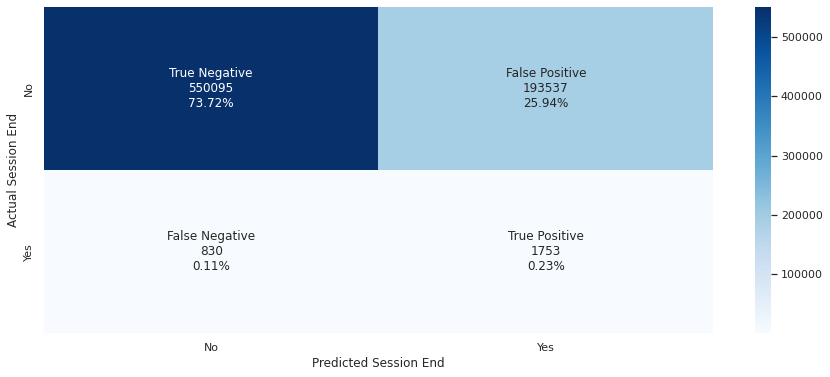

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_dt)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.heatmap(cm, annot = labels, fmt = '', cmap = 'Blues')
ax.set_xlabel('Predicted Session End')
ax.set_ylabel('Actual Session End')
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

In [ ]:
y_test.value_counts()

0    743632
1      2583
Name: session_ending_bet, dtype: int64

In [ ]:
y_test.value_counts(normalize = True)

0    0.996539
1    0.003461
Name: session_ending_bet, dtype: float64

**Baseline balanced accuracy**
- A baseline balanced accuracy acts as a lower bound to evaluate the performances of the machine learning models. The baseline model will be defined as the dummy predictor where it will **predict the majority class (session will not end or 0) all the time**. A trained model is usually expected to perform better than the baseline model. Otherwise, there is no reason to use the model.
- Given that the baseline model predicts 0 all the time, the **specificity will be 1 (able to detect all negatives)**. This is because there will be no false positives since the model only predict negatives (0). Plugging these values into the specificity formula will result in the value 1.
- On the other hand, the **recall will be 0**. Since the baseline model predicts a session not ending (0) all the time, it will never predict a session ending (1). Therefore, true positives equal 0. The false negatives will be the the marginal probability P(y = 1): 0.003461. Since the numeratior is 0, plugging these values into the recall formula will result in 0.
- Baseline balanced accuracy = (Sensitivity + Specificity) / 2 = (0 + 1) / 2 = **0.5 or 50%**
- Decision tree has **better balanced accuracy (70.9205%)** than the baseline model.

Obtain the feature importance based on the best decision tree
- Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. 
- Each node probability can be calculated by the number of samples that reach it, divided by the total number of samples. The higher the value the more important the feature.

In [ ]:
dt_imp = list(best_dt.feature_importances_)
dt_colname = list(X.columns)
dt_dict = {'Column Names': dt_colname,
           'Feature Importance': dt_imp}
dt_feature_imp = pd.DataFrame(dt_dict)
dt_feature_rank = dt_feature_imp.sort_values(by = 'Feature Importance', ascending = False).reset_index(drop = True)
dt_feature_rank['Rank'] = [i+1 for i in range(len(dt_feature_rank))]
dt_feature_rank

,Column Names,Feature Importance,Rank
0,sess_len_min,0.356295,1
1,withdrew_funds,0.349212,2
2,lost_money,0.149123,3
3,lowered_wager,0.114781,4
4,loss_streak_counter,0.030589,5


## **Feature selection based on recursive feature elimination of logistic regression**
- RFE searches for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number is achieved.
- This is achieved by fitting the given machine learning algorithm (logistic regression in this case), ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.
  - Model needs to have some coefficient or feature importance calculation internally

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

Ranking of features based on their importance in predicting the session ending

In [ ]:
model_rfe = LogisticRegression(random_state = 42, class_weight = 'balanced')
rfe = RFE(estimator = model_rfe, 
          n_features_to_select = 1)
rfe_fit = rfe.fit(X_train, y_train)
rank = list(rfe_fit.ranking_)
col_names = list(X.columns)
dict_rank = {'Column_Name': col_names,
             'Ranking':rank}
df_rank = pd.DataFrame(dict_rank)
df_rank.sort_values('Ranking').reset_index(drop = True)

,Column_Name,Ranking
0,lowered_wager,1
1,withdrew_funds,2
2,lost_money,3
3,loss_streak_counter,4
4,sess_len_min,5


In [ ]:
y_pred_rfe = rfe_fit.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rfe).ravel()
specificity = tn / (tn + fp)

In [ ]:
print("Precision: ", round(precision_score(y_test, y_pred_rfe) * 100, 4), "%")
print("Recall (Sensitivity): ", round(recall_score(y_test, y_pred_rfe) * 100, 4), "%")
print("Specificity: ", round(specificity * 100, 4), "%")
print("Balanced accuracy: ", round(balanced_accuracy_score(y_test, y_pred_rfe) * 100, 4), "%")

Precision:  6.9084 %
Recall (Sensitivity):  8.5559 %
Specificity:  99.5995 %
Balanced accuracy:  54.0777 %


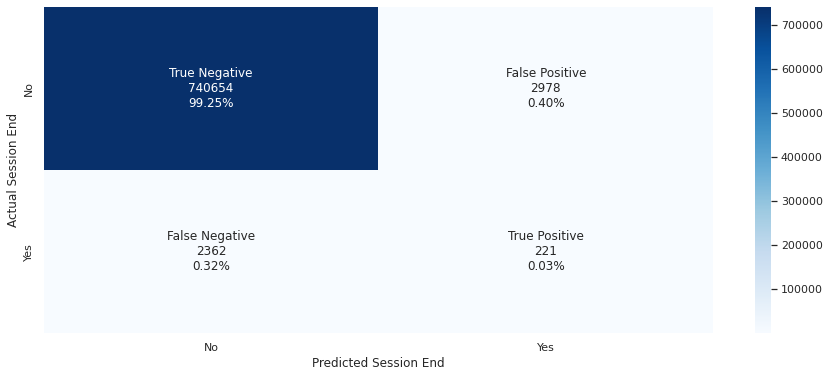

In [ ]:
cm = confusion_matrix(y_test, y_pred_rfe)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.heatmap(cm, annot = labels, fmt = '', cmap = 'Blues')
ax.set_xlabel('Predicted Session End')
ax.set_ylabel('Actual Session End')
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()